In [2]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from collections import defaultdict
from loguru import logger

from plot import ecdf
from geogiant.common.files_utils import load_json, dump_csv, dump_json, load_csv
from geogiant.common.settings import PathSettings

path_settings = PathSettings()


def greedy_set_cover_algorithm(maximum_set_number: int, sets: dict):
    # Defensive copies

    sets_copy = deepcopy(sets)

    # Compute the union of all sets
    # Get all bgp prefixes
    space = set()
    for _, bgp_prefixes in sets_copy.items():
        space.update(bgp_prefixes)

    if maximum_set_number is None or maximum_set_number > len(sets_copy):
        maximum_set_number = len(sets_copy)

    selected_sets = []
    while len(selected_sets) < maximum_set_number and len(space) > 0:

        # Select the set with the biggest intersection
        best_set = set()
        best_set_elements = set()
        for hostname, bgp_prefixes in sets_copy.items():
            # The score of the a set if the score of the weights
            additional_elements = space.intersection(bgp_prefixes)

            if len(additional_elements) > len(best_set_elements):
                best_set = hostname
                best_set_elements = additional_elements

        selected_sets.append(best_set)
        space = space - best_set_elements

        del sets_copy[best_set]

    return selected_sets

In [3]:
cdn_per_hostname = load_json(path_settings.DATASET / "hostname_1M_organization.json")

# Overall analysis

# bgp prefix per hostname

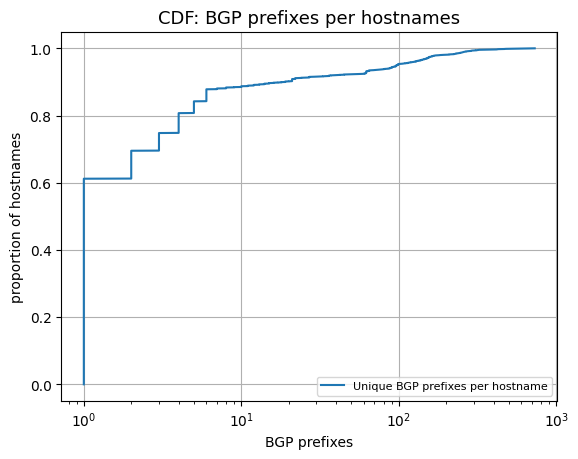

In [4]:
bgp_prefix_per_hostname = defaultdict(set)
for hostname, bgp_prefixes_per_cdn in cdn_per_hostname.items():
    for cdn, bgp_prefixes in bgp_prefixes_per_cdn.items():
        if cdn not in ["AMAZON-02", "GOOGLE"]:
            for bgp_prefix in bgp_prefixes:
                bgp_prefix_per_hostname[hostname].add(bgp_prefix)

fig, ax1 = plt.subplots(1, 1)

x, y = ecdf([len(p) for p in bgp_prefix_per_hostname.values()])
ax1.plot(x, y, label=f"Unique BGP prefixes per hostname")

plt.xlabel("BGP prefixes")
plt.ylabel("proportion of hostnames")
plt.legend(loc="lower right", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: BGP prefixes per hostnames",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "bgp_prefixes_per_hostnames.pdf")
plt.show()

## Hostname per CDNs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


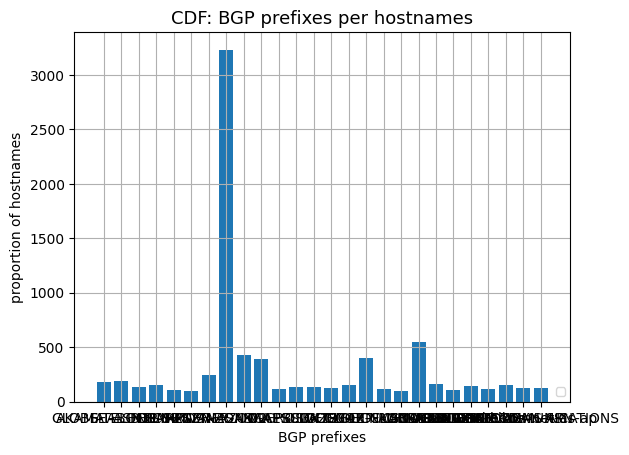

In [5]:
bgp_prefix_per_hostname = defaultdict(set)
for hostname, bgp_prefixes_per_cdn in cdn_per_hostname.items():
    for cdn, bgp_prefixes in bgp_prefixes_per_cdn.items():
        for bgp_prefix in bgp_prefixes:
            bgp_prefix_per_hostname[hostname].add(bgp_prefix)

hostname_per_cdn = defaultdict(set)
for hostname in cdn_per_hostname:
    for org, bgp_prefixes in cdn_per_hostname[hostname].items():
        hostname_per_cdn[org].add(hostname)

fig, ax1 = plt.subplots(1, 1)

hostname_per_cdn = [
    (org, len(hostnames)) for org, hostnames in hostname_per_cdn.items()
]

x = [org for org, nb_hostname in hostname_per_cdn if nb_hostname > 100]
height = [nb_hostname for _, nb_hostname in hostname_per_cdn if nb_hostname > 100]
width = 0.8

ax1.bar(x, height)


plt.xlabel("BGP prefixes")
plt.ylabel("proportion of hostnames")
plt.legend(loc="lower right", fontsize=8)
plt.grid()
plt.title(
    f"CDF: BGP prefixes per hostnames",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "bgp_prefixes_per_hostnames.pdf")
plt.show()

# BGP prefix greedy selection

In [6]:
bgp_prefix_per_hostname = defaultdict(set)
for hostname, bgp_prefixes_per_cdn in cdn_per_hostname.items():
    for cdn, bgp_prefixes in bgp_prefixes_per_cdn.items():
        for bgp_prefix in bgp_prefixes:
            bgp_prefix_per_hostname[hostname].add(bgp_prefix)

hostname_greedy_selection = greedy_set_cover_algorithm(
    maximum_set_number=1000,
    sets=bgp_prefix_per_hostname,
)

dump_csv(
    data=hostname_greedy_selection,
    output_file=path_settings.DATASET / "hostname_1M_greedy_bgp.csv",
)

# Max bgp prefix per CDN

In [20]:
bgp_prefix_per_hostname = defaultdict(set)
for hostname, bgp_prefixes_per_cdn in cdn_per_hostname.items():
    for cdn, bgp_prefixes in bgp_prefixes_per_cdn.items():
        for bgp_prefix in bgp_prefixes:
            bgp_prefix_per_hostname[hostname].add(bgp_prefix)

hostname_per_cdn = defaultdict(list)
for hostname in cdn_per_hostname:
    for org, bgp_prefixes in cdn_per_hostname[hostname].items():
        hostname_per_cdn[org].append((hostname, len(set(bgp_prefixes))))

max_bgp_prefix_hostname_per_cdn = defaultdict(dict)
elected_max_bgp_prefix = set()
filtered_data = defaultdict(list)
for org, hostname_bgp_prefixes in hostname_per_cdn.items():

    # take only hostnames that have the most bgp prefix per Org
    hostname_bgp_prefixes = sorted(
        hostname_bgp_prefixes, key=lambda x: x[1], reverse=True
    )

    # take only org with many bpg prefixes (threshold to 10)
    if hostname_bgp_prefixes[0][1] < 10:
        continue

    filtered_data[org] = hostname_bgp_prefixes[:10]

    max_bgp_prefix_hostname_per_cdn[org] = hostname_bgp_prefixes[:10]

    logger.info(f"Org:: {org}, total nb hostname: {len(hostname_bgp_prefixes)}")
    for hostname, nb_bgp_prefixes in hostname_bgp_prefixes[:10]:
        elected_max_bgp_prefix.add(hostname)
        logger.info(f"{hostname=}, {nb_bgp_prefixes=}")

dump_json(
    data=filtered_data,
    output_file=path_settings.DATASET / "hostname_1M_max_bgp_prefix_per_cdn.json",
)
dump_csv(
    data=elected_max_bgp_prefix,
    output_file=path_settings.DATASET / "hostname_1M_max_bgp_prefix_per_cdn.csv",
)

2024-03-11 19:38:40.519 | INFO     | __main__:<module>:30 - Org:: AKAMAI-ASN1, total nb hostname: 180
2024-03-11 19:38:40.520 | INFO     | __main__:<module>:33 - hostname='www.flexispot.jp', nb_bgp_prefixes=483
2024-03-11 19:38:40.521 | INFO     | __main__:<module>:33 - hostname='jetourchile.cl', nb_bgp_prefixes=438
2024-03-11 19:38:40.522 | INFO     | __main__:<module>:33 - hostname='www.segueviagem.com.br', nb_bgp_prefixes=390
2024-03-11 19:38:40.522 | INFO     | __main__:<module>:33 - hostname='m.sports.khan.co.kr', nb_bgp_prefixes=381
2024-03-11 19:38:40.523 | INFO     | __main__:<module>:33 - hostname='www.oref.org.il', nb_bgp_prefixes=357
2024-03-11 19:38:40.523 | INFO     | __main__:<module>:33 - hostname='www.uptak.in', nb_bgp_prefixes=320
2024-03-11 19:38:40.524 | INFO     | __main__:<module>:33 - hostname='www.dirtrider.com', nb_bgp_prefixes=316
2024-03-11 19:38:40.525 | INFO     | __main__:<module>:33 - hostname='www.flexispot.es', nb_bgp_prefixes=316
2024-03-11 19:38:40.526

In [8]:
logger.info(f"total NB Orgs: {len(max_bgp_prefix_hostname_per_cdn)}")

for org, hostnames in max_bgp_prefix_hostname_per_cdn.items():
    logger.info(f"{org}, nb hostnames : {len(hostnames)}")

2024-03-11 19:35:19.411 | INFO     | __main__:<module>:1 - total NB Orgs: 34
2024-03-11 19:35:19.413 | INFO     | __main__:<module>:4 - AKAMAI-ASN1, nb hostnames : 10
2024-03-11 19:35:19.414 | INFO     | __main__:<module>:4 - SEABONE-NET, nb hostnames : 10
2024-03-11 19:35:19.415 | INFO     | __main__:<module>:4 - BBIL-AP, nb hostnames : 10
2024-03-11 19:35:19.416 | INFO     | __main__:<module>:4 - AMAZON-02, nb hostnames : 10
2024-03-11 19:35:19.417 | INFO     | __main__:<module>:4 - AMAZON-AES, nb hostnames : 10
2024-03-11 19:35:19.418 | INFO     | __main__:<module>:4 - OVH, nb hostnames : 10
2024-03-11 19:35:19.418 | INFO     | __main__:<module>:4 - INCAPSULA, nb hostnames : 10
2024-03-11 19:35:19.419 | INFO     | __main__:<module>:4 - CDN77, nb hostnames : 10
2024-03-11 19:35:19.419 | INFO     | __main__:<module>:4 - ZEN-ECN, nb hostnames : 10
2024-03-11 19:35:19.420 | INFO     | __main__:<module>:4 - KAOPU-HK, nb hostnames : 10
2024-03-11 19:35:19.421 | INFO     | __main__:<module

In [9]:
logger.info(f"total NB Hostnames: {len(elected_max_bgp_prefix)}")

for hostname in elected_max_bgp_prefix:
    logger.info(f"{hostname=}")

2024-03-11 19:35:19.448 | INFO     | __main__:<module>:1 - total NB Hostnames: 223
2024-03-11 19:35:19.451 | INFO     | __main__:<module>:4 - hostname='m.sporx.com'
2024-03-11 19:35:19.452 | INFO     | __main__:<module>:4 - hostname='pagoenlinea.santanderconsumer.cl'
2024-03-11 19:35:19.453 | INFO     | __main__:<module>:4 - hostname='www.rancakmedia.com'
2024-03-11 19:35:19.454 | INFO     | __main__:<module>:4 - hostname='afiliados.carglass.com.br'
2024-03-11 19:35:19.455 | INFO     | __main__:<module>:4 - hostname='packagist.org'
2024-03-11 19:35:19.456 | INFO     | __main__:<module>:4 - hostname='www.oref.org.il'
2024-03-11 19:35:19.457 | INFO     | __main__:<module>:4 - hostname='storage.googleapis.com'
2024-03-11 19:35:19.457 | INFO     | __main__:<module>:4 - hostname='m.sports.khan.co.kr'
2024-03-11 19:35:19.458 | INFO     | __main__:<module>:4 - hostname='r2beat-ko.valofe.com'
2024-03-11 19:35:19.459 | INFO     | __main__:<module>:4 - hostname='m.superfb.com'
2024-03-11 19:35:1

In [ ]:
logger.info(f"total NB Hostnames: {len(elected_max_bgp_prefix)}")

for hostname in elected_max_bgp_prefix:
    logger.info(f"{hostname=}")

2024-03-11 19:35:19.448 | INFO     | __main__:<module>:1 - total NB Hostnames: 223
2024-03-11 19:35:19.451 | INFO     | __main__:<module>:4 - hostname='m.sporx.com'
2024-03-11 19:35:19.452 | INFO     | __main__:<module>:4 - hostname='pagoenlinea.santanderconsumer.cl'
2024-03-11 19:35:19.453 | INFO     | __main__:<module>:4 - hostname='www.rancakmedia.com'
2024-03-11 19:35:19.454 | INFO     | __main__:<module>:4 - hostname='afiliados.carglass.com.br'
2024-03-11 19:35:19.455 | INFO     | __main__:<module>:4 - hostname='packagist.org'
2024-03-11 19:35:19.456 | INFO     | __main__:<module>:4 - hostname='www.oref.org.il'
2024-03-11 19:35:19.457 | INFO     | __main__:<module>:4 - hostname='storage.googleapis.com'
2024-03-11 19:35:19.457 | INFO     | __main__:<module>:4 - hostname='m.sports.khan.co.kr'
2024-03-11 19:35:19.458 | INFO     | __main__:<module>:4 - hostname='r2beat-ko.valofe.com'
2024-03-11 19:35:19.459 | INFO     | __main__:<module>:4 - hostname='m.superfb.com'
2024-03-11 19:35:1

# Greedy selection per CDN

In [10]:
hostname_per_cdn = defaultdict(dict)
for hostname in cdn_per_hostname:
    for org, bgp_prefixes in cdn_per_hostname[hostname].items():
        hostname_per_cdn[org][hostname] = bgp_prefixes

elected_hostnames = set()
elected_cdns = set()
elected_hostname_per_cdn = defaultdict(dict)
for org, bgp_prefix_per_hostname in hostname_per_cdn.items():
    greedy_hostnames = greedy_set_cover_algorithm(10, bgp_prefix_per_hostname)
    greedy_hostnames = set(greedy_hostnames)

    # if we do not have enough hostnames, add some more to the mix
    # if len(greedy_hostnames) < 10:
    #     for hostname, bgp_prefixes in bgp_prefix_per_hostname.items():
    #         if len(greedy_hostnames) >= 10:
    #             break

    #         if len(bgp_prefixes) > 10:
    #             greedy_hostnames.add(hostname)

    for hostname in greedy_hostnames:
        bgp_prefixes = bgp_prefix_per_hostname[hostname]
        if not len(bgp_prefixes) > 10:
            continue

        elected_hostname_per_cdn[org][hostname] = bgp_prefixes
        logger.info(f"{org=}, {hostname=}, {len(bgp_prefixes)=}")
        elected_hostnames.add(hostname)
        elected_cdns.add(org)

dump_csv(
    data=elected_hostnames,
    output_file=path_settings.DATASET / "hostname_1M_cdn_greedy_cdn.csv",
)

2024-03-11 19:35:19.755 | INFO     | __main__:<module>:28 - org='AKAMAI-ASN1', hostname='www.atlantis.com', len(bgp_prefixes)=236
2024-03-11 19:35:19.758 | INFO     | __main__:<module>:28 - org='AKAMAI-ASN1', hostname='m.hkjc.com', len(bgp_prefixes)=255
2024-03-11 19:35:19.760 | INFO     | __main__:<module>:28 - org='AKAMAI-ASN1', hostname='www.hawaiicounty.gov', len(bgp_prefixes)=237
2024-03-11 19:35:19.761 | INFO     | __main__:<module>:28 - org='AKAMAI-ASN1', hostname='www.flexispot.jp', len(bgp_prefixes)=483
2024-03-11 19:35:19.766 | INFO     | __main__:<module>:28 - org='AKAMAI-ASN1', hostname='community.wyndham.com', len(bgp_prefixes)=248
2024-03-11 19:35:19.769 | INFO     | __main__:<module>:28 - org='AKAMAI-ASN1', hostname='nuovavenezia.gelocal.it', len(bgp_prefixes)=212
2024-03-11 19:35:19.770 | INFO     | __main__:<module>:28 - org='AKAMAI-ASN1', hostname='m.sports.khan.co.kr', len(bgp_prefixes)=381
2024-03-11 19:35:19.771 | INFO     | __main__:<module>:28 - org='AKAMAI-ASN1'

2024-03-11 19:35:20.105 | INFO     | __main__:<module>:28 - org='AMAZON-02', hostname='www.pinchme.com', len(bgp_prefixes)=429
2024-03-11 19:35:20.107 | INFO     | __main__:<module>:28 - org='AMAZON-02', hostname='d2vhk3w56tqrcl.cloudfront.net', len(bgp_prefixes)=97
2024-03-11 19:35:20.111 | INFO     | __main__:<module>:28 - org='AMAZON-02', hostname='www.amazon.com.br', len(bgp_prefixes)=101
2024-03-11 19:35:20.112 | INFO     | __main__:<module>:28 - org='AMAZON-02', hostname='www.audible.com.au', len(bgp_prefixes)=94
2024-03-11 19:35:20.113 | INFO     | __main__:<module>:28 - org='AMAZON-02', hostname='wendys.csod.com', len(bgp_prefixes)=99
2024-03-11 19:35:20.114 | INFO     | __main__:<module>:28 - org='AMAZON-02', hostname='br.888casino.com', len(bgp_prefixes)=124
2024-03-11 19:35:20.114 | INFO     | __main__:<module>:28 - org='AMAZON-02', hostname='d-90672c00e9.awsapps.com', len(bgp_prefixes)=101
2024-03-11 19:35:20.115 | INFO     | __main__:<module>:28 - org='AMAZON-02', hostname

In [11]:
logger.info(f"CDNs:: {len(elected_cdns)}")
for cdn in elected_cdns:
    logger.info(f"{cdn}")

2024-03-11 19:35:20.442 | INFO     | __main__:<module>:1 - CDNs:: 28
2024-03-11 19:35:20.444 | INFO     | __main__:<module>:3 - FACEBOOK
2024-03-11 19:35:20.445 | INFO     | __main__:<module>:3 - ALIBABA-CN-NET
2024-03-11 19:35:20.446 | INFO     | __main__:<module>:3 - CDN77
2024-03-11 19:35:20.446 | INFO     | __main__:<module>:3 - CHINAMOBILE-CN
2024-03-11 19:35:20.447 | INFO     | __main__:<module>:3 - KAOPU-HK
2024-03-11 19:35:20.449 | INFO     | __main__:<module>:3 - ZEN-ECN
2024-03-11 19:35:20.450 | INFO     | __main__:<module>:3 - STARK-INDUSTRIES
2024-03-11 19:35:20.450 | INFO     | __main__:<module>:3 - INCAPSULA
2024-03-11 19:35:20.451 | INFO     | __main__:<module>:3 - Taobao
2024-03-11 19:35:20.452 | INFO     | __main__:<module>:3 - AMAZON-AES
2024-03-11 19:35:20.453 | INFO     | __main__:<module>:3 - AS-HOSTINGER
2024-03-11 19:35:20.454 | INFO     | __main__:<module>:3 - GOOGLE
2024-03-11 19:35:20.454 | INFO     | __main__:<module>:3 - ACE-AS-AP
2024-03-11 19:35:20.455 | I

In [12]:
logger.info(f"Hostnames:: {len(elected_hostnames)}")
for hostname in elected_hostnames:
    logger.info(f"{hostname}")

dump_csv(elected_hostnames, path_settings.DATASET / "elected_hostnames.csv")

2024-03-11 19:35:20.474 | INFO     | __main__:<module>:1 - Hostnames:: 84
2024-03-11 19:35:20.477 | INFO     | __main__:<module>:3 - webgb.huchua.com
2024-03-11 19:35:20.478 | INFO     | __main__:<module>:3 - storage.googleapis.com
2024-03-11 19:35:20.479 | INFO     | __main__:<module>:3 - m.sports.khan.co.kr
2024-03-11 19:35:20.481 | INFO     | __main__:<module>:3 - m.superfb.com
2024-03-11 19:35:20.482 | INFO     | __main__:<module>:3 - www.citilink.co.id
2024-03-11 19:35:20.483 | INFO     | __main__:<module>:3 - www.droid8k.com
2024-03-11 19:35:20.484 | INFO     | __main__:<module>:3 - setupgame.ma
2024-03-11 19:35:20.485 | INFO     | __main__:<module>:3 - liuxue.koolearn.com
2024-03-11 19:35:20.492 | INFO     | __main__:<module>:3 - pcrdfans.com
2024-03-11 19:35:20.492 | INFO     | __main__:<module>:3 - nuovavenezia.gelocal.it
2024-03-11 19:35:20.493 | INFO     | __main__:<module>:3 - chelyabinsk.tele2.ru
2024-03-11 19:35:20.493 | INFO     | __main__:<module>:3 - www.iwanttfc.com
2

In [13]:
for cdn, hostnames in elected_hostname_per_cdn.items():
    logger.info(f"CDN:: {cdn}, nb elected_hostnames : {len(hostnames)}")
    elected_hostname_per_cdn[cdn] = list(hostnames)
    for hostname in hostnames:
        logger.info(hostname)
    logger.info("##########################################")

dump_json(
    data=elected_hostname_per_cdn,
    output_file=path_settings.DATASET / "hostname_per_cdn_1M.json",
)

2024-03-11 19:35:20.579 | INFO     | __main__:<module>:2 - CDN:: AKAMAI-ASN1, nb elected_hostnames : 10
2024-03-11 19:35:20.580 | INFO     | __main__:<module>:5 - www.atlantis.com
2024-03-11 19:35:20.580 | INFO     | __main__:<module>:5 - m.hkjc.com
2024-03-11 19:35:20.581 | INFO     | __main__:<module>:5 - www.hawaiicounty.gov
2024-03-11 19:35:20.582 | INFO     | __main__:<module>:5 - www.flexispot.jp
2024-03-11 19:35:20.582 | INFO     | __main__:<module>:5 - community.wyndham.com
2024-03-11 19:35:20.583 | INFO     | __main__:<module>:5 - nuovavenezia.gelocal.it
2024-03-11 19:35:20.583 | INFO     | __main__:<module>:5 - m.sports.khan.co.kr
2024-03-11 19:35:20.584 | INFO     | __main__:<module>:5 - www.iwanttfc.com
2024-03-11 19:35:20.585 | INFO     | __main__:<module>:5 - jetourchile.cl
2024-03-11 19:35:20.585 | INFO     | __main__:<module>:5 - www.segueviagem.com.br
2024-03-11 19:35:20.586 | INFO     | __main__:<module>:6 - ##########################################
2024-03-11 19:35:

In [14]:
def greedy_weighted_set_cover_algorithm(
    self, maximum_set_number: int, sets: dict, weights: dict, with_analyze: bool
):
    assert type(sets) == dict
    # Defensive copies
    sets = dict(sets)
    weights = dict(weights)

    # Compute the union of all sets
    # Get all bgp prefixes
    space = set()
    for _, s in self.ips_per_destination_source.items():
        space.update(s)

    if maximum_set_number is None or maximum_set_number > len(
        self.ips_per_destination_source
    ):
        maximum_set_number = len(self.ips_per_destination_source)

    if with_analyze:
        cumulative_weights = []
        cumulative_ips = []

    selected_sets = []
    while len(selected_sets) < maximum_set_number and len(space) > 0:
        print(len(selected_sets))
        # Select the set with the biggest intersection
        best_set = None
        best_additional_weight = -1
        best_set_elements = None
        for s, elements in sets.items():
            # The score of the a set if the score of the weights
            additional_elements = space.intersection(elements)
            additional_weight = self.weight(additional_elements, weights)
            if additional_weight > best_additional_weight:
                best_set = s
                best_additional_weight = additional_weight
                best_set_elements = additional_elements

        selected_sets.append(best_set)
        space = space - best_set_elements
        if with_analyze:
            if len(cumulative_weights) == 0:
                cumulative_weights.append(best_additional_weight)
                cumulative_ips.append(len(best_set_elements))
            else:
                cumulative_weights.append(
                    best_additional_weight + cumulative_weights[-1]
                )
                cumulative_ips.append(len(best_set_elements) + cumulative_ips[-1])
        del sets[best_set]

    if with_analyze:
        # Normalize cumulative weights
        total_weight = sum(weights.values())
        cumulative_weights = [x / total_weight for x in cumulative_weights]
        cumulative_ips = [x / len(weights) for x in cumulative_ips]

        return selected_sets, cumulative_weights, cumulative_ips
    return selected_sets